# Inverse applications

By David Ortiz and Rodrigo Salas, 2024

Interesting paper about [parameter estimation](https://arxiv.org/abs/2308.00927) in blood flown problem.

## Activity overview

In this activity, we will code a PINN to estimate the diffusion coefficient of the linear 1D heat equation.

## Activity goals

By the end of this activity, you should be able to:

 - use the PINN method to solve inverse problem,
 - while, training a PINN to solve the diffusion problem


## Mathematical description of the problem
In this activity, we will consider the one dimensional diffusion model, usually called 1D heat equation, defined on activity 2, i.e., 
$$
\begin{alignat*}{3}
    \text{PDE:} \quad & \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)), \quad && x \in [-1, 1], \quad t \in [0, 1]. \quad \kappa\in\mathbb{R}\\
    \text{Solution:} \quad & u(t,x) &&= e^{-t} \sin(\pi x)
\end{alignat*}
$$

where $u(t,x)$ is the quantity of interest (e.g., temperature, concentration) at the point $x\in[-1,1]$ and at time $t\in[0,1]$ and $\kappa = 1$ **is the diffusion coefficient that we want to estimate**. The main idea is to treat $\kappa$ as a free parameter when the PINN is train. Thus, we train the PINN to solve the model, while we find the true value of the parameter. 

Notice that for this case, we do not need the initial conditions and the boundary conditions, but we need additional information in terms of noisy observations $u_{data}(t,x)$. This will be explained below.



## Initial setup

We begin by importing some usefull packages, and defining some functions

In [21]:
%matplotlib widget

In [22]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
# Import a utility module 
import utils 
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

# torch definition of pi number
torch.pi = torch.acos(torch.zeros(1)).item() * 2


# Function to calculate the relative l2 error
def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.norm(u_num - u_ref, p=2)
    
    # Calculate the L2 norm of the reference
    l2_ref = torch.norm(u_ref, p=2)
    
    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2


# Function to plot the solutions
def plot_comparison(u_true, u_pred, loss, k_evol):
    
    # Convert tensors to numpy arrays for plotting
    u_pred_np = u_pred.detach().numpy()

    # Create a figure with 4 subplots
    fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the true values
    im1 = axs[0].imshow(u_true, extent=[-1,1,1,0])
    axs[0].set_title('Analytic solution for diffusion')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$t$')
    fig1.colorbar(im1, spacing='proportional',
                            shrink=0.5, ax=axs[0])

    # Plot the predicted values
    im2 = axs[1].imshow(u_pred_np, extent=[-1,1,1,0])
    axs[1].set_title('PINN solution for diffusion')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$t$')
    fig1.colorbar(im2, spacing='proportional',
                            shrink=0.5, ax=axs[1])
    # Display the plot
    plt.tight_layout()
    plt.show()


    # Plot the loss values recorded during training
    # Create a figure with 2 subplots
    fig2, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot the difference between the predicted and true values
    axs[0].plot(k_evol, label="PINN estimate")
    axs[0].hlines(1, 0, len(k_evol), label="True value", color="tab:green")
    axs[0].set_title(r"$\kappa$ evolution")
    axs[0].set_xlabel("Iteration")
    
    axs[1].plot(loss)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_title('Training Progress')
    axs[1].grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()
    
    
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect 
    to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        retain_graph=True,  
                        )[0]
    

### Analytical solution (observations)
Once again, we define the analytical solution $u(t,x) = e^{-t}\sin(\pi x)$. For this task, the `analytic_diffusion` will be used to generate the observation data and as reference for comparison purposes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


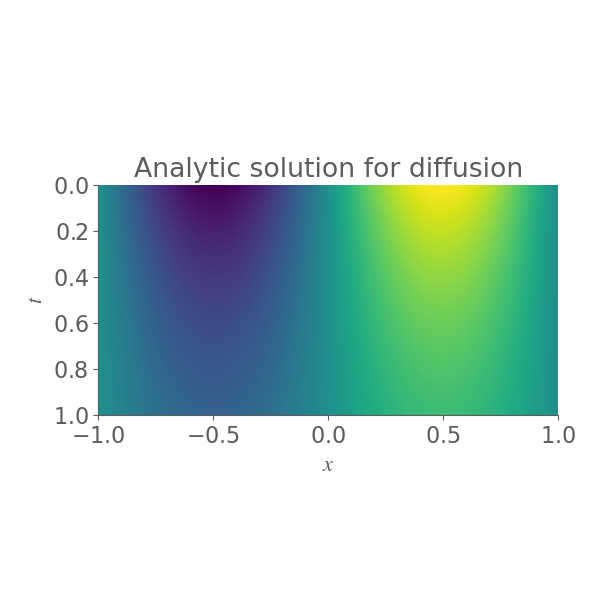

In [23]:
# Number of samples in x and t
dom_samples = 100

# Function for the diffusion analytical solution
def analytic_diffusion(x,t):
    u = np.exp(-t)*np.sin(np.pi*x)
    return u

# spatial domain
x = np.linspace(-1, 1, dom_samples)
# temporal domain
t = np.linspace(0, 1, dom_samples)

# Domain mesh
X, T = np.meshgrid(x, t)
U = analytic_diffusion(X, T)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(U, extent=[-1,1,1,0])
ax.set_title('Analytic solution for diffusion')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$') 
ax.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()

## Training the Physics-informed Neural Network
To train the PINN, we will generate the domain using the `LatinHypercube` sampling (LHS) strategy. LHS ensures that the samples evenly cover the input space ensuring that the samples are not clustered in a small area, but are distributed over the entire space. 

We import the `qmc.LatinHypercube` from `scipy.stats` and scale it to the boundaries of the domain. Also, we convert the temporal domain and the observations to `torch.tensors`

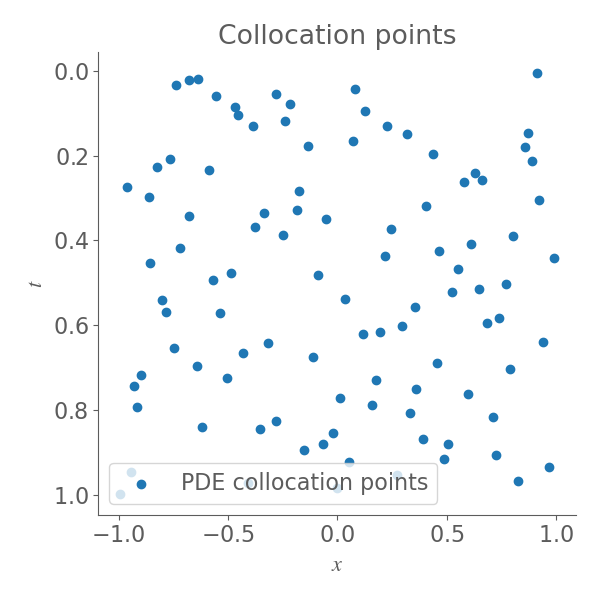

In [24]:
from scipy.stats import qmc
# LHS sampling strategy
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=100)

# lower and upper boundas of the domain
l_bounds = [-1, 0]
u_bounds = [ 1, 1]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# torch tensors
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
t_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(domain_xt[:, 0],domain_xt[:, 1], label = 'PDE collocation points')
ax.set_title('Collocation points')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$') 
ax.legend(loc='lower left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Also, we evaluate the `analytic_diffusion` function on this collocation points and add some noise to get the observation data $u_{data}(t,x)$, i.e.,

In [25]:
# evaluate sample points in analytical function
x_np = x_ten.detach().numpy()
t_np = t_ten.detach().numpy()
u_true = analytic_diffusion(x_np,t_np).reshape(1, -1)
u_observ = u_true + np.random.normal(0,0.01,len(x_np))
# convert observations in Pytorch tensors
u_observ_t = torch.tensor(u_observ, requires_grad = True).float().reshape(-1,1)

As mentioned above, we will perform the $\kappa$ parameter estimation at the same time as the PINN is trained. To this end, we train the ANN to directly approximate the solution to the partial differential equation and include $\kappa$ as a free parameters, i.e.,

$$
u_{PINN}(t, x; \Theta, \kappa) \approx u(t,x)
$$

where $\Theta$ are the free (trainable) parameters of the ANN. Now, we use `PyTorch` and define the neural network and, for this task, we will use the ADAM optimizer.

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> Parameter k is added to the optimizer, not to the ANN
</div>

In [26]:
torch.manual_seed(123)

# training parameters
hidden_layers = [2, 20, 20, 20, 1]
learning_rate = 0.001
training_iter = 40000

In [27]:
# Define a loss function (Mean Squared Error) for training the network
MSE_func = nn.MSELoss()

# Define a neural network class with user defined layers and neurons
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)
    

In [28]:
# Create an instance of the neural network 
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')


# treat k as a learnable parameter
kappa = torch.nn.Parameter(torch.ones(1, requires_grad=True)*2)
kappas = []

# add k to the optimiser
# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(list(u_pinn.parameters())+[kappa], lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 921


### Physics-Informed Loss function
To train the PINN, we recall the diffusion model and define function $f_{pde}(t, x)$ for the PDE. Also, we replace the analytical solution $u(t,x)$ with the PINN output $u_{pinn}(t,x; \Theta)$:

$$
\begin{align*}
f_{pde}(t,x;u_{pinn}):=& \frac{\partial u}{\partial t} - \kappa\frac{\partial^2 y}{\partial x^2} + e^{-t}(\sin(\pi x) - \pi^2  \sin(\pi x)) = 0\\
\end{align*}
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> We do not need the boundary and initial conditions
</div>

Once again we use the $MSE$ and define the physics-informed loss function:

$$
\begin{align*}
\mathcal{L}(\theta):&= \frac{\lambda_1}{N}\sum_i\left(f_{pde}(t_i,x_i;u_{pinn})-0\right)^2 \quad \text{PDE loss}\\
                   & + \frac{\lambda_2}{N}\sum_i\left(u_{PINN}(t_i,x_i; \Theta) - \theta_{data}(t_i,x_i)\right)^2 \quad \text{DATA loss}
\end{align*}
$$

where $\lambda_{1,2}\in\mathbb{R}^+$ are positive (weigth) numbers, and $N$ is the number of samples. 

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> For inverse problem data-driven escheme is used.
</div>

The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$



In [29]:
def PINN_diffusion_Loss(forward_pass, x_ten, t_ten,
             lambda1 = 1, lambda2 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - kappa*u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten) 
                                        -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # Data loss
    data_loss = lambda2 * MSE_func(u, u_observ_t)
    
    return PDE_loss + data_loss
    
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):
    
    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = PINN_diffusion_Loss(u_pinn, x_ten, t_ten)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    kappas.append(kappa.item())

    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 17.35139274597168
Iteration 1000: Loss 0.025037258863449097
Iteration 2000: Loss 0.022397249937057495
Iteration 3000: Loss 0.020020509138703346
Iteration 4000: Loss 0.01639898680150509
Iteration 5000: Loss 0.010048743337392807
Iteration 6000: Loss 0.0021677655167877674
Iteration 7000: Loss 0.0006129721878096461
Iteration 8000: Loss 0.00036140746669843793
Iteration 9000: Loss 0.0003453211975283921
Iteration 10000: Loss 0.00030982657335698605
Iteration 11000: Loss 0.0002117749972967431
Iteration 12000: Loss 0.0001642815041122958
Iteration 13000: Loss 0.0001535954070277512
Iteration 14000: Loss 0.000144730118336156
Iteration 15000: Loss 0.00013865545042790473
Iteration 16000: Loss 0.00013386546925175935
Iteration 17000: Loss 0.00013043884246144444
Iteration 18000: Loss 0.0001265860628336668
Iteration 19000: Loss 0.0001262775040231645
Iteration 20000: Loss 0.00039718675543554127
Iteration 21000: Loss 0.00012269111175555736
Iteration 22000: Loss 0.0015071582747623324
Itera

Relative error: 0.007013966329395771


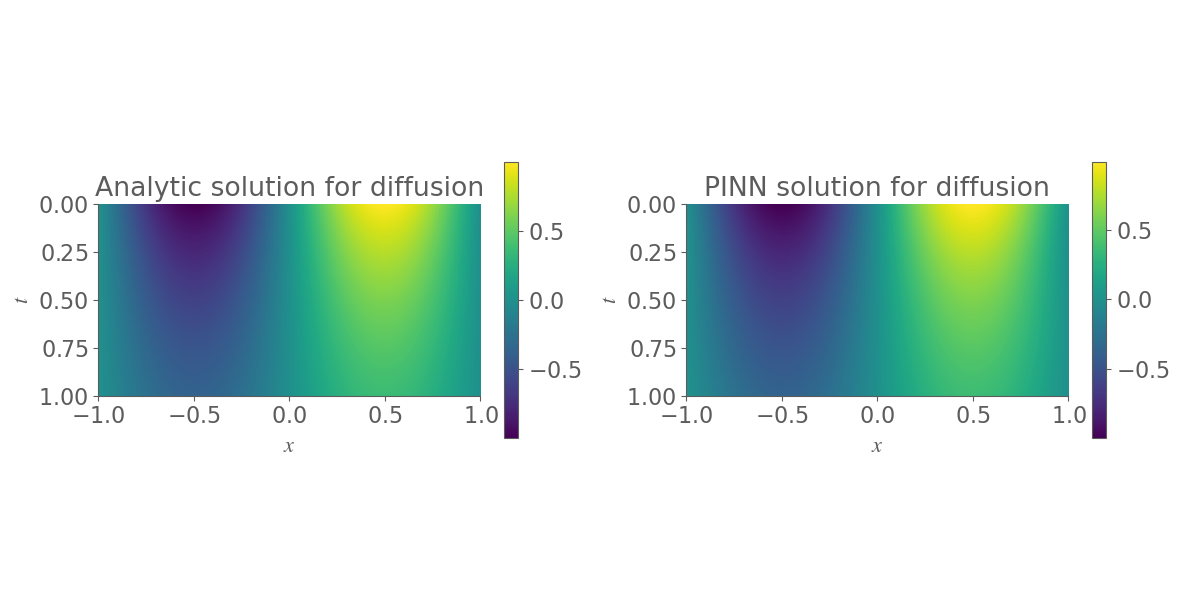

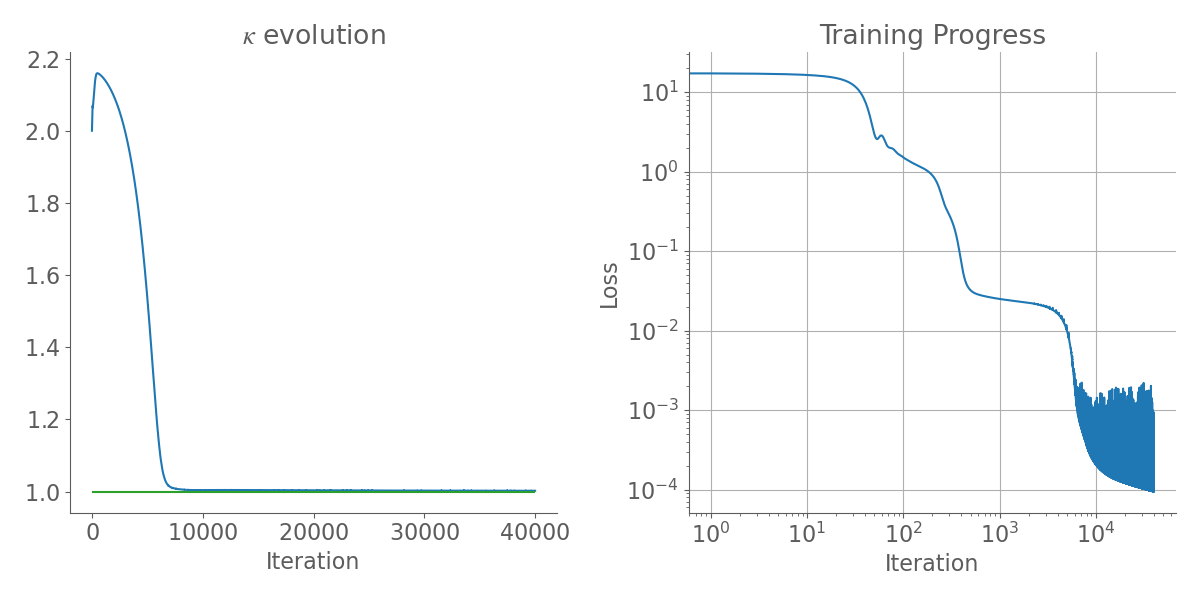

In [30]:
X_ten = torch.tensor(X).float().reshape(-1, 1)
T_ten = torch.tensor(T).float().reshape(-1, 1)
domain_ten = torch.cat([T_ten, X_ten], dim = 1)
U_pred = u_pinn(domain_ten).reshape(dom_samples,dom_samples)

U_true = torch.tensor(U).float()
print(f'Relative error: {relative_l2_error(U_pred, U_true)}')

plot_comparison(U, U_pred, loss_values, kappas)